In [ ]:
import re
import csv
import sys


def extract_log_data(input_filename, output_filename="output.csv"):
    """
    Extracts step data from a log file and saves it to a CSV file.

    Args:
        input_filename (str): Path to the input log file.
        output_filename (str): Path to the output CSV file.
    """

    # Regex to find the marker line to start processing
    start_marker_regex = re.compile(r"Adj_matrix size:")

    # Regex to capture the data from the relevant "Step" lines
    # Captures: 1: Step number, 2: Accept Rate, 3: Candidate Length,
    #           4: Accept Length, 5: Best Path Index
    data_regex = re.compile(
        r"^Step\s+(\d+):\s+"  # Step number
        r"accept rate:\s+([\d.]+),\s+"  # Accept rate (float)
        r"candidate length:\s+(\d+),\s+"  # Candidate length (int)
        r"accept length:\s+(\d+),\s+"  # Accept length (int)
        # r"best path index:\s+(\d+),"             # Best path index (int)
        # r".*best path input:\s+(tensor\(.+?\))\s*" # Optionally capture tensor
        r".*"  # Match rest of the line
    )

    start_processing = False
    extracted_data = []

    print(f"Reading from: {input_filename}")
    try:
        with open(input_filename, "r", encoding="utf-8") as infile:
            for line_num, line in enumerate(infile, 1):
                # Strip leading/trailing whitespace
                line = line.strip()

                # Check if we should start processing
                if not start_processing:
                    if start_marker_regex.search(line):
                        print(
                            f"Found start marker on line {line_num}. Starting data extraction..."
                        )
                        start_processing = True
                    continue  # Skip lines until marker is found

                # If processing has started, try to match the data line pattern
                match = data_regex.match(line)
                if match:
                    # Extract captured groups
                    step = match.group(1)
                    accept_rate = match.group(2)
                    candidate_length = match.group(3)
                    accept_length = match.group(4)
                    # best_path_index = match.group(5)
                    # tensor_input = match.group(6) # If you wanted the tensor

                    extracted_data.append(
                        [
                            step,
                            accept_rate,
                            candidate_length,
                            accept_length,
                            # best_path_index
                            # tensor_input # If needed
                        ]
                    )

    except FileNotFoundError:
        print(f"Error: Input file '{input_filename}' not found.")
        return
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return

    if not extracted_data:
        print("Warning: No data matching the pattern was found after the start marker.")
        return

    # Write the extracted data to a CSV file
    print(f"Writing extracted data to: {output_filename}")
    try:
        with open(output_filename, "w", newline="", encoding="utf-8") as outfile:
            writer = csv.writer(outfile)
            # Write header
            header = [
                "Step",
                "Accept Rate",
                "Candidate Length",
                "Accept Length",
                # "Best Path Index",
                # "Best Path Input" # If needed
            ]
            writer.writerow(header)
            # Write data rows
            writer.writerows(extracted_data)
        print("Processing complete. CSV file created successfully.")

    except Exception as e:
        print(f"An error occurred while writing the CSV file: {e}")
        sys.exit(1)


# Replace 'your_log_file.log' with the actual path to your log file
log_file_path = "../log/test.log"
# You can change the output CSV filename if needed
csv_file_path = "extracted_log_data.csv"

extract_log_data(log_file_path, csv_file_path)


Reading from: ../log/test.log
Found start marker on line 122165. Starting data extraction...
Writing extracted data to: extracted_log_data.csv
Processing complete. CSV file created successfully.


In [12]:
import torch

tensor = torch.tensor([1, 2, 3])
print(tensor)
print(tensor.shape)
print(tensor[None, None])
print(tensor[None, None].shape)

tensor = tensor.unsqueeze(0)
print(tensor)
print(tensor.shape)
print(tensor.dim())
print(tensor[:, :-1])


tensor([1, 2, 3])
torch.Size([3])
tensor([[[1, 2, 3]]])
torch.Size([1, 1, 3])
tensor([[1, 2, 3]])
torch.Size([1, 3])
2
tensor([[1, 2]])


In [6]:
import pandas as pd

df = pd.read_csv(csv_file_path)
df

,Step,Accept Rate,Candidate Length,Accept Length
0,1,0.03,7,1
1,2,0.03,7,1
2,3,0.12,7,2
3,4,0.20,7,2
4,5,0.03,7,1
...,...,...,...,...
36059,82,0.75,7,5
36060,83,0.33,7,3
36061,84,0.20,7,3
36062,85,1.00,7,7


Successfully loaded data from 'extracted_log_data.csv'

Average Accept Rate per Step (first 10):
Step
1     0.064460
2     0.132668
3     0.157491
4     0.208587
5     0.258986
6     0.284649
7     0.313974
8     0.312505
9     0.305463
10    0.327395
Name: Accept Rate, dtype: float64

Smoothed Average Accept Rate (Window=10, first 10):
Step
1     0.164438
2     0.184473
3     0.202974
4     0.216665
5     0.226531
6     0.236618
7     0.260840
8     0.281533
9     0.296385
10    0.309099
Name: Accept Rate, dtype: float64


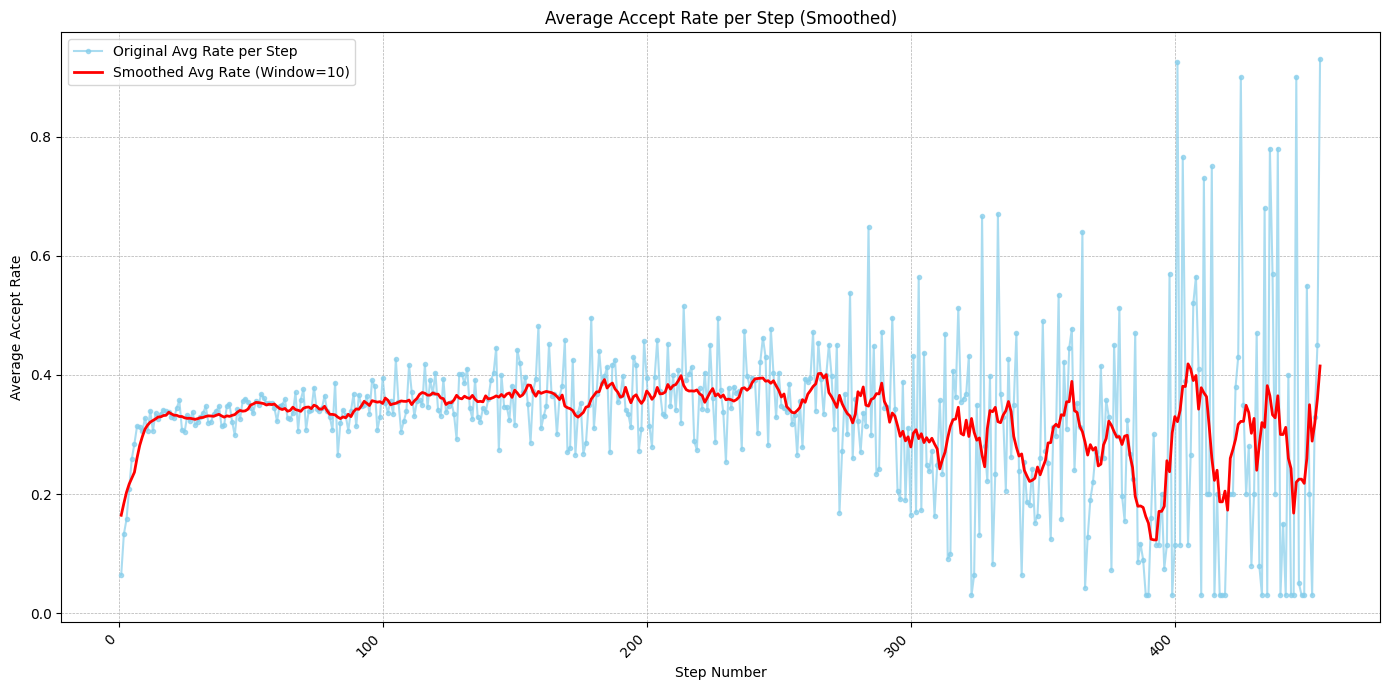

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
csv_filename = "extracted_log_data.csv"  # Make sure this matches your CSV file name
window_size = 10  # <--- Define the size of the sliding window (adjust as needed)

# --- Load the data ---
try:
    df = pd.read_csv(csv_filename)
    print(f"Successfully loaded data from '{csv_filename}'")
    # print("First 5 rows:")
    # print(df.head())
    # print("\nData types:")
    # print(df.dtypes)

except FileNotFoundError:
    print(f"Error: CSV file '{csv_filename}' not found.")
    print(
        "Please make sure the previous script ran successfully and the CSV file exists."
    )
    sys.exit(1)
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    sys.exit(1)

# --- Data Preparation ---
# Ensure 'Step' and 'Accept Rate' are numeric
df["Step"] = pd.to_numeric(df["Step"], errors="coerce")
df["Accept Rate"] = pd.to_numeric(df["Accept Rate"], errors="coerce")

# Drop rows where conversion failed
original_rows = len(df)
df.dropna(subset=["Step", "Accept Rate"], inplace=True)
if len(df) < original_rows:
    print(
        f"\nWarning: Dropped {original_rows - len(df)} rows due to non-numeric values in 'Step' or 'Accept Rate'."
    )

df["Step"] = df["Step"].astype(int)

# --- Calculate Average Accept Rate per Step ---
avg_rates_by_step = df.groupby("Step")["Accept Rate"].mean()

print("\nAverage Accept Rate per Step (first 10):")
print(avg_rates_by_step.head(10))

# --- Calculate Smoothed Average Rate ---
if not avg_rates_by_step.empty:
    # Ensure window size isn't larger than the data
    actual_window_size = min(window_size, len(avg_rates_by_step))
    if actual_window_size < window_size:
        print(
            f"\nWarning: Requested window size ({window_size}) > data points ({len(avg_rates_by_step)}). Using window size {actual_window_size}."
        )

    # Calculate the rolling mean.
    # 'center=True' makes the window centered on the current point (needs data before and after)
    # which often gives a better visual smoothing of the underlying trend.
    # 'min_periods=1' calculates even if the window isn't full (useful at edges).
    smoothed_rates = avg_rates_by_step.rolling(
        window=actual_window_size, center=True, min_periods=1
    ).mean()
    print(f"\nSmoothed Average Accept Rate (Window={actual_window_size}, first 10):")
    print(smoothed_rates.head(10))

else:
    smoothed_rates = pd.Series(dtype=float)  # Create empty series if no data

# --- Plotting ---
if avg_rates_by_step.empty:
    print("\nNo data available to plot after processing.")
else:
    plt.figure(figsize=(14, 7))  # Adjust figure size

    # Plot the original average rates (optional, but good for comparison)
    # Make it slightly less prominent
    avg_rates_by_step.plot(
        marker=".",
        linestyle="-",
        color="skyblue",
        alpha=0.7,
        label="Original Avg Rate per Step",
    )

    # Plot the smoothed average rates
    smoothed_rates.plot(
        linestyle="-",
        color="red",
        linewidth=2,
        label=f"Smoothed Avg Rate (Window={actual_window_size})",
    )

    # Add labels and title
    plt.title("Average Accept Rate per Step (Smoothed)")
    plt.xlabel("Step Number")
    plt.ylabel("Average Accept Rate")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=45, ha="right")

    # Add legend to identify the lines
    plt.legend()

    plt.tight_layout()
    plt.show()



Data with 'question' column (first few rows and tails):
       Step  Accept Rate  Candidate Length  Accept Length  question
0         1         0.03                 7              1         0
1         2         0.03                 7              1         0
2         3         0.12                 7              2         0
3         4         0.20                 7              2         0
4         5         0.03                 7              1         0
36059    82         0.75                 7              5       564
36060    83         0.33                 7              3       564
36061    84         0.20                 7              3       564
36062    85         1.00                 7              7       564
36063    86         0.57                 7              4       564

Detected 565 unique questions (numbered 0 to 564).

Aggregated data for plot (first few rows):
   question  Step  Accept Rate
0         0     1         0.03
1         0     2         0.03
2     

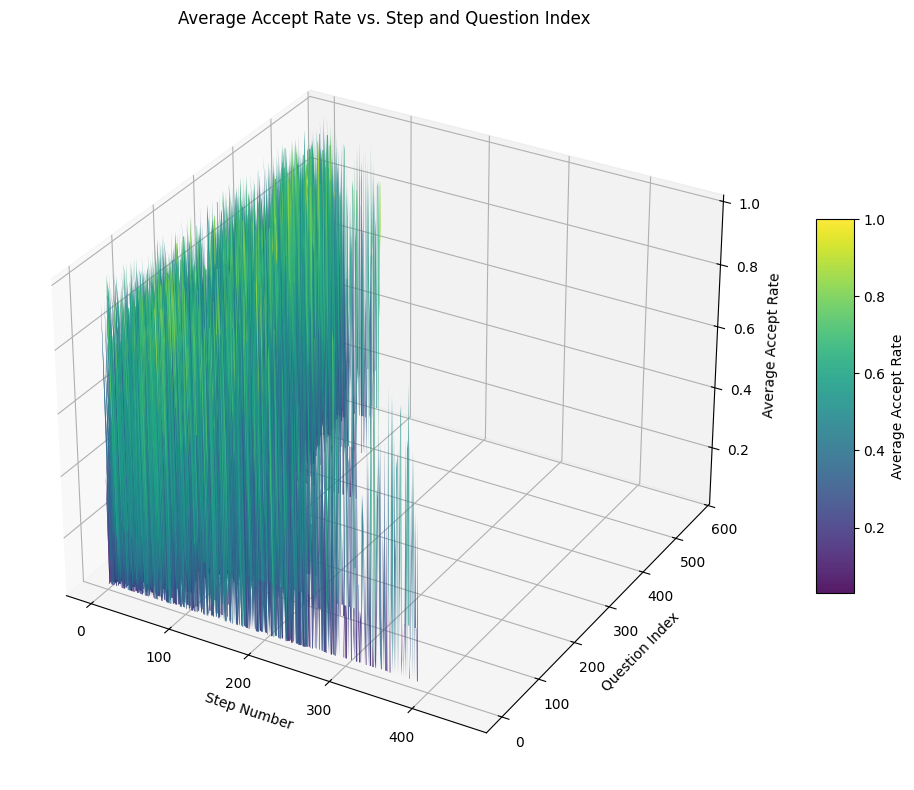

Plot displayed.


In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# --- Add the 'question' column ---
# A new 'question' starts when Step is 1 and the previous Step was > 1
# We use shift() to look at the previous row's Step value.
# fill_value=0 handles the very first row correctly.
is_new_question_start = (df["Step"] == 1) & (df["Step"].shift(1, fill_value=0) != 1)

# Calculate the question number using cumulative sum
df["question"] = is_new_question_start.cumsum()

# Since cumsum() starts counting from 1 for the first occurrence,
# and we want 0-based indexing for 'question', subtract 1.
# However, the first block should be question 0. The first True will make cumsum 1.
# So, the result of cumsum() is already the correct 1-based index *of the question*.
# Let's make it 0-based if that's preferred:
df["question"] = df["question"] - 1

print("\nData with 'question' column (first few rows and tails):")
print(pd.concat([df.head(), df.tail()]))
print(
    f"\nDetected {df['question'].nunique()} unique questions (numbered 0 to {df['question'].max()})."
)


# --- Aggregate data for plotting ---
# Group by question and step, calculate mean accept rate
plot_data = df.groupby(["question", "Step"])["Accept Rate"].mean().reset_index()
print("\nAggregated data for plot (first few rows):")
print(plot_data.head())

# --- Prepare data grid for surface plot ---
# Pivot the table to get Steps as columns, questions as rows, and Accept Rate as values
try:
    surface_data = plot_data.pivot(
        index="question", columns="Step", values="Accept Rate"
    )
except IndexError as e:
    print(f"\nError during pivot: {e}")
    print(
        "This might happen if there are duplicate (question, Step) pairs after grouping, which shouldn't occur with .mean(). Check data."
    )
    sys.exit(1)


print("\nPivoted data for surface plot (shape: rows=questions, columns=steps):")
print(surface_data.shape)
# print(surface_data.head()) # Can be large, print shape instead

# Get Step numbers (X) and question numbers (Y)
step_values = surface_data.columns.values
question_values = surface_data.index.values

# Create a meshgrid for the surface plot
X, Y = np.meshgrid(step_values, question_values)

# Get the Accept Rate values (Z)
# Need to handle potential NaNs if some (question, Step) combos don't exist
# plot_surface can handle NaNs (masked arrays), or we can fill them (e.g., with 0)
Z = surface_data.values
# Z = surface_data.fillna(0).values # Optional: Fill NaNs with 0


# --- Create the 3D Surface Plot ---
if Z.size == 0:
    print("\nNo data available to plot after pivoting.")
else:
    print("\nGenerating 3D surface plot...")
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    # cmap options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'coolwarm', 'jet', etc.
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        cmap="viridis",
        edgecolor="none",
        antialiased=True,
        rstride=1,
        cstride=1,
        alpha=0.9,
    )  # Added params for potentially better look

    # Set labels and title
    ax.set_xlabel("Step Number")
    ax.set_ylabel("Question Index")
    ax.set_zlabel("Average Accept Rate")
    ax.set_title("Average Accept Rate vs. Step and Question Index")

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=10, label="Average Accept Rate")

    # Improve view angle (optional)
    # ax.view_init(elev=30, azim=-60) # Adjust elevation and azimuth angle

    plt.tight_layout()
    plt.show()
    print("Plot displayed.")


In [ ]:
# find the smallest max step number of all questions
min_step = df.groupby("question")["Step"].max().min()
min_step

ndf = df[df["Step"] <= min_step]
# plot the avg first 4 step accept rate for each question
avg_acc = ndf.groupby("question")["Accept Rate"].mean()

print(avg_acc)


question
0      0.0950
1      0.1175
2      0.2700
3      0.0725
4      0.2100
        ...  
560    0.3600
561    0.0300
562    0.0300
563    0.0725
564    0.0725
Name: Accept Rate, Length: 565, dtype: float64
